# Introductoin
- lightGBM

# Import everythng I nead :)

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

## load data

In [2]:
cancer = load_breast_cancer()
feature_names = cancer.feature_names
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [3]:
X = df.values
y = cancer.target

# lightGBM(not using test data)

## set params

In [4]:
# Configuration
N_ESTIMATORS = 1000          # 最大学習回数
VERBOSE = 200               # 200回ごとに評価する
EARLY_STOPPING_ROUNDS = 100  # 100回の学習でよくならなければ、学習をとめる
RANDOM_STATE = 42
METRIC = accuracy_score

# lgb_params
lgb_params = {'num_leaves': 31,
          'min_child_samples': 30,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

## K-Fold

**3 fold**

In [5]:
n_folds = 3
folds = KFold(n_splits=n_folds, shuffle=True)

score_list = []
models = []
feature_importance = pd.DataFrame()
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print('------------------')
    print(f'- fold{fold_n + 1}' )
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Train the model
    model = lgb.LGBMClassifier(**lgb_params, n_estimators=N_ESTIMATORS, n_jobs=-1)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)
    
    
    # predict
    oof = model.predict(X_valid, num_iteration=model.best_iteration_)   # oof: out of folds
    score_list.append(round(METRIC(y_valid, oof), 4))
    
    # feature_importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = feature_names
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    

print('------------------')
print('====== finish ======')
print('score list:', score_list)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(score_list), np.std(score_list)))

------------------
- fold1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[24]	training's l1: 0.0623155	valid_1's l1: 0.0975945
------------------
- fold2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	training's l1: 0.0583865	valid_1's l1: 0.120822
------------------
- fold3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	training's l1: 0.0689411	valid_1's l1: 0.0930949
------------------
====== finish ======
score list: [0.9421, 0.9579, 0.9471]
CV mean score: 0.9490, std: 0.0066.


## plot feature importance

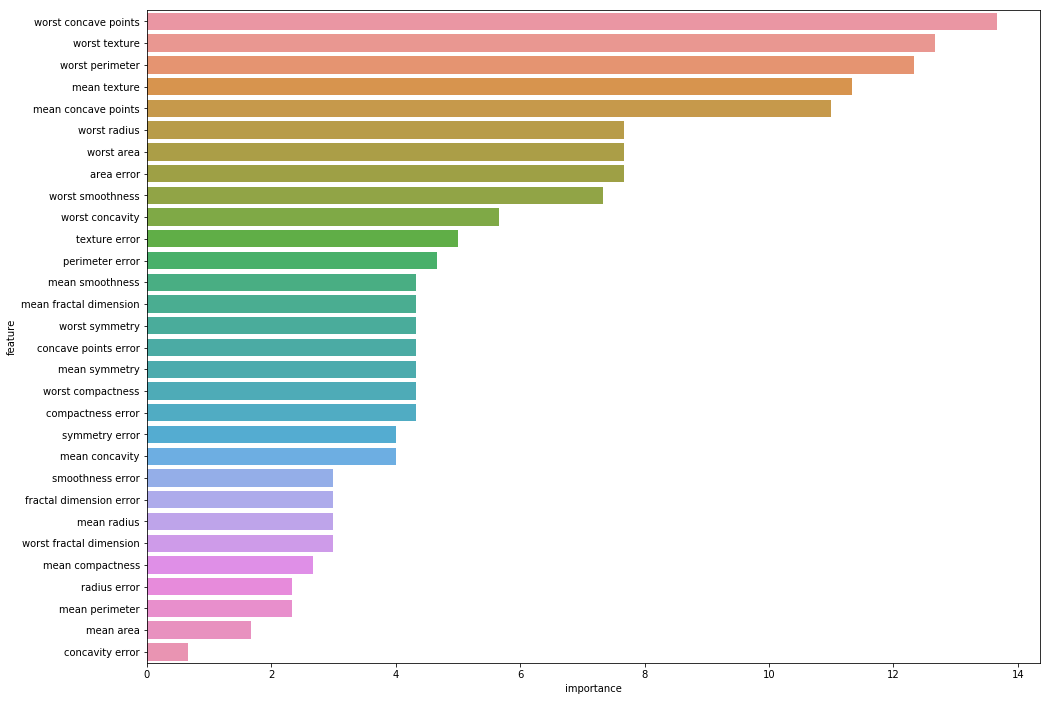

In [6]:
# top 50 features
best_features = feature_importance.groupby(['feature']).mean().sort_values('importance', ascending=False)[:50]
plt.figure(figsize=(16, 12))
sns.barplot(x='importance', y=best_features.index, data=best_features)